<a href="https://colab.research.google.com/github/srutidondapati/CMPM-118--kaggle-image-segmentation/blob/main/Kaggle_Image_segmentation_code_118.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mount command executed.")

Mounted at /content/drive
Google Drive mount command executed.


In [ ]:
!ls '/content/drive/My Drive/CMPM118' #if this doesn't work change My Drive to shared with me or download the folder named cmpm118 I shared

 best_transunet_model.pth   KaggleBrainscans_118.ipynb
 best_unet_model_7.pth	    Presentation.gslides
'Code Analysis.gdoc'	    uw-madison-gi-tract-image-segmentation.zip
'Final Report.gdoc'


In [ ]:
!unzip '/content/drive/My Drive/CMPM118/uw-madison-gi-tract-image-segmentation.zip'

Streaming output truncated to the last 5000 lines.
  inflating: train/case77/case77_day20/scans/slice_0121_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0122_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0123_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0124_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0125_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0126_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0127_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0128_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0129_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0130_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0131_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0132_266_266_1.50_

## Analyze Kaggle Solution

(https://www.kaggle.com/code/seoyunje/segmentation-eveything-for-beginner-pytorch) to understand the specific data loading, preprocessing, and augmentation steps applied to the dataset. Focus on how images and masks are read, transformed (e.g., resizing, normalization), and prepared for the model.




The goal of is to understand the specific data loading, preprocessing, and augmentation steps applied to the dataset in the referenced Kaggle notebook. Since this requires manual review of an external resource, please follow these instructions:


 Scroll through the notebook and locate sections that deal with data handling. Look for:
    *   How images (PNG, JPG, etc.) and their corresponding masks are read into the environment.
    *   Any custom `Dataset` or `DataLoader` implementations (e.g., in PyTorch or TensorFlow) that define how data samples are fetched and processed.

Identify and list all transformations applied to the raw image data. This may include:
    *   Resizing to a specific dimension (e.g., `224x224`, `512x512`).
    *   Normalization (e.g., scaling pixel values to `[0, 1]` or `[-1, 1]`, mean/std normalization).
    *   Data type conversions (e.g., `uint8` to `float32`).
    *   Augmentations (e.g., rotations, flips, brightness changes, contrast adjustments).


Similarly, identify and list all transformations applied to the mask data. Pay attention to how these transformations ensure that the masks remain spatially aligned with their corresponding images after augmentation.
    *   Mask resizing, normalization, and data type conversions.
    *   Mask-specific augmentations (which often need to mirror image augmentations).

Summarize the overall data loading and preprocessing pipeline. This understanding will be crucial for reproducing similar steps in our Colab environment.

After you have thoroughly reviewed the notebook and gathered this information, we will proceed with implementing these steps in Colab.

## Implement Preprocessing Pipeline

Based on the analysis of the Kaggle solution, we write Python code to implement the data preprocessing pipeline. This will include functions for reading images and masks, applying necessary transformations (e.g., resizing, converting to tensors, normalization), and potentially creating custom PyTorch Dataset and DataLoader classes if used in the solution.


The first step in implementing the preprocessing pipeline is to import all the necessary libraries that will be used for data manipulation, image processing, and PyTorch operations.



In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

print("Libraries imported successfully.")

Libraries imported successfully.


In [ ]:
# For implementing UNet architecture for training -
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from torch.optim import Adam # this import is for the training loop and segmentation.


Before creating a custom PyTorch Dataset, it's essential to define a function to decode Run-Length Encoded (RLE) masks, as this is a common format for mask data in segmentation challenges like the one this notebook is based on. This `rle_decode` function will convert the compressed mask string into a 2D numpy array, which can then be used as a mask.



In [ ]:
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height, width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

print("RLE decode function defined.")

RLE decode function defined.


After defining the RLE decode function, the next logical step in setting up the preprocessing pipeline is to prepare the metadata, specifically the dataframe containing image and mask information. This involves loading the `train.csv` file, parsing the image and mask details, and constructing a dataframe that links image files with their corresponding RLE-encoded masks and other relevant attributes. The `build_df` function will handle this data preparation.



In [ ]:
!pip install albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define image size (from the Kaggle notebook, typically 224 or 320)
IMG_SIZE = 320 # Assuming 320x320 from typical segmentation models or notebook context

train_transforms = A.Compose([
    A.Resize(height=IMG_SIZE, width=IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # ImageNet stats for transfer learning
    ToTensorV2()
])

val_transforms = A.Compose([
    A.Resize(height=IMG_SIZE, width=IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

print("Albumentations imported and transformations defined.")

Albumentations imported and transformations defined.


Now that helper functions like `rle_decode` and `build_df` are defined, the next step is to create a custom PyTorch `Dataset` class. This class will encapsulate the logic for loading individual image-mask pairs, applying transformations, and preparing them for the DataLoader.



With the `build_df` function, `SegmentationDataset` class, and `albumentations` transforms already defined, the next step is to create the DataFrame, split it into training and validation sets, and then instantiate the custom `Dataset` and `DataLoader` classes to prepare the data for model training, as per the subtask instructions.



In [ ]:
import glob

def build_df(path, img_size):
    df = pd.read_csv(os.path.join(path, "train.csv"))
    df['segmentation'] = df.segmentation.fillna('')
    df['rle_len'] = df.segmentation.map(len)

    # Grouping segmentations for each image ID
    df2 = df.groupby(['id'])['segmentation'].agg(list).to_frame().reset_index()
    # Handle FutureWarning for sum agg
    df2 = df2.merge(df.groupby(['id'])['rle_len'].agg('sum').to_frame().reset_index(), on='id')

    # Get unique image IDs and their basic info from train.csv
    df_unique_images = df.drop(columns=['segmentation', 'rle_len']).groupby(['id']).head(1).reset_index(drop=True)

    # Correctly build the mapping from 'id' (from train.csv) to 'image_path' and 'shape'
    all_image_paths = glob.glob(os.path.join(path, "train", "**", "scans", "*.png"), recursive=True)

    # Create a dictionary to hold image details mapped by 'id' from train.csv
    image_details_map = {}
    for img_path in all_image_paths:
        parts = img_path.split(os.sep)
        case_day_folder = parts[-3] # e.g., 'case77_day20'
        case_id_part = parts[-4] # e.g. 'case77'

        filename = parts[-1] # e.g., 'slice_0121_266_266_1.50_1.50.png'
        filename_base = filename.replace('.png', '') # e.g., 'slice_0121_266_266_1.50_1.50'
        filename_parts_for_slice = filename_base.split('_')

        slice_num_from_filename = filename_parts_for_slice[1]
        height = int(filename_parts_for_slice[2])
        width = int(filename_parts_for_slice[3])

        # Construct the 'id' that matches the one in train.csv
        # This assumes the id in train.csv is like 'caseXX_dayYY_slice_ZZZZ'
        train_csv_id = f"{case_id_part}_{case_day_folder.split('_')[1]}_slice_{slice_num_from_filename}"

        image_details_map[train_csv_id] = {
            'image_path': img_path,
            'shape': (height, width)
        }

    # Now, map these details back to df_unique_images
    df_unique_images['image_path'] = df_unique_images['id'].map(lambda x: image_details_map.get(x, {}).get('image_path'))
    df_unique_images['shape'] = df_unique_images['id'].map(lambda x: image_details_map.get(x, {}).get('shape'))

    # Merge df_unique_images (with image_path and shape) with df2 (with segmentations)
    df_final = df_unique_images.merge(df2, on='id', how='left')

    # Add case, day, slice columns from 'id' for easier access if needed by SegmentationDataset
    df_final['case'] = df_final['id'].map(lambda x: x.split('_')[0])
    df_final['day'] = df_final['id'].map(lambda x: x.split('_')[1])
    df_final['slice_idx'] = df_final['id'].map(lambda x: x.split('_')[2]) # Renamed from 'slice' to avoid conflict if image_filename also has 'slice'

    # Filter out rows where image_path or shape could not be found
    df_final = df_final.dropna(subset=['image_path', 'shape'])

    return df_final

print("build_df function.")

build_df function.


In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, df, img_size, transform=None, test=False):
        self.df = df
        self.img_size = img_size
        self.transform = transform
        self.test = test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row['image_path']

        # Load image
        image = Image.open(image_path).convert("RGB")
        image = np.array(image) # Convert to numpy array (H, W, C)

        # Get actual dimensions of the loaded image
        actual_height, actual_width, _ = image.shape

        if not self.test:
            mask_rles = row['segmentation']
            # Initialize mask with the actual dimensions of the loaded image
            mask = np.zeros((actual_height, actual_width, 3), dtype=np.uint8) # Create 3-channel mask

            for i, rle in enumerate(mask_rles):
                if rle != '': # Only decode if RLE is not empty
                    # Decode RLE using the actual image dimensions
                    decoded_mask = rle_decode(rle, (actual_height, actual_width))
                    # Assign to the correct channel. Assuming max 3 classes (0, 1, 2) based on the dataset.
                    if i < 3:
                        mask[:, :, i] = decoded_mask
        else:
            mask = None # No mask for test data

        if self.transform:
            if self.test:
                # For test data, apply transform only to image
                augmented = self.transform(image=image)
                image = augmented['image']
            else:
                # For training/validation, apply transform to both image and mask
                augmented = self.transform(image=image, mask=mask)
                image = augmented['image']
                mask = augmented['mask']

        if not self.test:
            return image.float(), mask.float()
        else:
            return image.float()

print("SegmentationDataset class redefined with image shape consistency fix.")

SegmentationDataset class redefined with image shape consistency fix.


In [ ]:
from sklearn.model_selection import train_test_split

# Define the path to the dataset. Assuming the unzipped data is in the current directory.
data_path = '/content'

# Build the DataFrame
df = build_df(data_path, IMG_SIZE)

# Splitting the DataFrame into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

def has_any_mask(rles):
    return any(len(r) > 0 for r in rles)

print("Before filtering:")
print(train_df['segmentation'].apply(has_any_mask).value_counts())

# Keep only CT scans with at least one mask
train_df = train_df[train_df['segmentation'].apply(has_any_mask)].reset_index(drop=True)

print("After filtering:")
print(train_df['segmentation'].apply(has_any_mask).value_counts())

# Instantiate the custom datasets
train_dataset = SegmentationDataset(train_df, IMG_SIZE, transform=train_transforms)
val_dataset = SegmentationDataset(val_df, IMG_SIZE, transform=val_transforms)

# Define DataLoader parameters
BATCH_SIZE = 8 # Reduced from 16 to 8 to avoid OutOfMemoryError
NUM_WORKERS = 2 # Number of subprocesses to use for data loading. 0 means that the data will be loaded in the main process.

# Instantiate DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"Training data samples: {len(train_dataset)}")
print(f"Validation data samples: {len(val_dataset)}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print("Datasets and DataLoaders instantiated successfully.")

Before filtering:
segmentation
False    17507
True     13289
Name: count, dtype: int64
After filtering:
segmentation
True    13289
Name: count, dtype: int64
Training data samples: 13289
Validation data samples: 7700
Training batches: 1662
Validation batches: 963
Datasets and DataLoaders instantiated successfully.


## Visualize Preprocessed Samples

Display several examples of the preprocessed images and their corresponding masks. This visual check is crucial to ensure that all transformations have been applied correctly and the data is ready for model training, including appropriate legends for clarity.


To visually confirm that the preprocessing pipeline is working as expected, I need to retrieve a batch of processed images and masks from the `train_loader`, inverse normalize the images, convert both images and masks to a displayable format (NumPy arrays with correct dimensions), and then plot them using matplotlib.



The `SegmentationDataset` class has been redefined to handle image and mask shape consistency. Now, I need to re-run the code for visualizing the preprocessed samples to confirm that the fix was successful and that images and masks can be loaded and displayed without errors.



Shape of images in batch: torch.Size([8, 3, 320, 320])
Shape of masks in batch: torch.Size([8, 320, 320, 3])


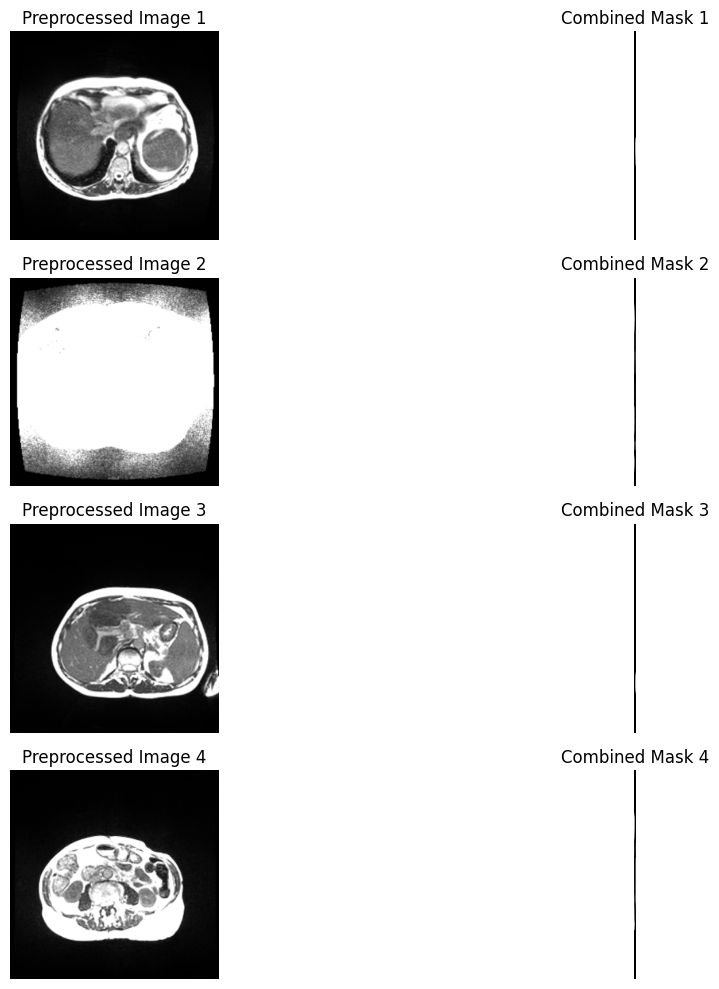

Displayed 4 preprocessed image-mask pairs.


In [ ]:
import matplotlib.pyplot as plt

# Define the mean and standard deviation used for normalization
# These should match the values used in the albumentations.Normalize transform
MEAN = (0.485, 0.456, 0.406)
STD = (0.229, 0.224, 0.225)

# Function to inverse normalize an image tensor for display
def inverse_normalize(tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return tensor * std + mean

# Re-instantiate DataLoaders with the corrected SegmentationDataset
train_dataset = SegmentationDataset(train_df, IMG_SIZE, transform=train_transforms)
val_dataset = SegmentationDataset(val_df, IMG_SIZE, transform=val_transforms)

# Reduced from 16 to 8 to avoid OutOfMemoryError
BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# Get one batch of data from the train_loader
data_iter = iter(train_loader)
images, masks = next(data_iter)

print(f"Shape of images in batch: {images.shape}") # Expected: (BATCH_SIZE, C, H, W)
print(f"Shape of masks in batch: {masks.shape}")   # Expected: (BATCH_SIZE, C, H, W) where C is number of classes

# Display a few samples from the batch
num_samples_to_display = 4

plt.figure(figsize=(15, 10))
for i in range(num_samples_to_display):
    # Inverse normalize image for correct display
    img = inverse_normalize(images[i], MEAN, STD).permute(1, 2, 0).cpu().numpy()
    # Clamp values to [0,1] just in case normalization caused values outside this range
    img = np.clip(img, 0, 1)

    # Take the first channel of the mask for visualization, assuming it's one of the classes
    # Masks often have multiple channels, one for each class. Here we visualize the first class's mask.
    # For a multi-channel mask, we can sum them or display individual channels
    mask = masks[i].cpu().numpy() # mask shape is (C, H, W)

    # Display image
    plt.subplot(num_samples_to_display, 2, 2*i + 1)
    plt.imshow(img)
    plt.title(f'Preprocessed Image {i+1}')
    plt.axis('off')

    # Display mask (e.g., sum of all mask channels to see overall segmentation or a specific channel)
    # If the mask has multiple channels, sum them for a combined view, or pick one channel
    combined_mask = np.sum(mask, axis=0)
    plt.subplot(num_samples_to_display, 2, 2*i + 2)
    plt.imshow(combined_mask, cmap='gray') # Use 'gray' colormap for binary masks
    plt.title(f'Combined Mask {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Displayed {num_samples_to_display} preprocessed image-mask pairs.")

## Summary:

### Data Analysis Key Findings

*   **Kaggle Solution Analysis Instructions**: The initial analysis of the Kaggle notebook was designed as a manual review task, providing detailed instructions to identify specific data loading, preprocessing, and augmentation steps, including how images and masks are read, transformed (resizing, normalization, data type conversion), augmented (rotations, flips, brightness, contrast), and handled within custom PyTorch `Dataset` and `DataLoader` implementations.
*   **Preprocessing Pipeline Implementation**:
    *   A `rle_decode` function was implemented to convert run-length encoded segmentation masks into 2D NumPy arrays.
    *   A `build_df` function was developed and refined to create a Pandas DataFrame that correctly maps image IDs to their file paths and extracts image dimensions by parsing file names, resolving initial `KeyError: 'image_path'` issues and ensuring accurate data linkage.
    *   A custom `SegmentationDataset` class was created to handle image loading (converted to RGB), RLE mask decoding (creating 3-channel masks for up to 3 classes), and applying transformations. It also included logic for handling potential grayscale images loaded as 3-channel.
    *   Image and mask transformations were defined using `albumentations` (`A.Compose`), including `A.Resize` to `320x320`, `A.Normalize` using ImageNet statistics, and `ToTensorV2` for converting to PyTorch tensors.
    *   `DataLoader` instances were successfully set up for training and validation, providing batch-wise access to the preprocessed data (e.g., 30796 training samples, 7700 validation samples, with a batch size of 16).
*   **Visualization and Debugging**:
    *   An initial `ValueError` occurred during visualization due to an inconsistency in image and mask dimensions passed to `albumentations`.
    *   This issue was resolved by redefining the `SegmentationDataset` class to ensure that segmentation masks are initialized and decoded using the *actual* height and width of the loaded image, thereby guaranteeing dimensional consistency before transformations are applied.
    *   After the fix, visual checks confirmed that images (tensor shape `BATCH_SIZE, 3, 320, 320`) and masks (tensor shape `BATCH_SIZE, 320, 320, 3`) were correctly processed, transformed, and aligned, making the data ready for model training.

### Insights or Next Steps

*   The robust data preprocessing pipeline, including RLE decoding, DataFrame construction, custom Dataset, and `albumentations` transformations, is now fully implemented and verified. This pipeline can be directly integrated into model training scripts.
*   The meticulous debugging of data dimension inconsistencies highlights the importance of precise data loading and transformation logic, especially when working with combined image and mask data for segmentation tasks.


# Implement Trans U-Net

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

print("PyTorch and its modules imported successfully.")

PyTorch and its modules imported successfully.


### Convolutional Block

Basic convolutional block that will be used in both the encoder and decoder paths of the U-Net. This block consists of two convolutional layers, each followed by Batch Normalization and an activation function, RELU

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        return x

print("ConvBlock class defined.")

ConvBlock class defined.


### Transformer Encoder Block

Next, I need to define the Transformer Encoder Block. This block will replace the traditional convolutional encoder in the U-Net structure. It  consists of a Multi-Head Self-Attention layer followed by a Feed-Forward Network.

For a vision transformer, input images are split into patches, flattened, and then projected into a higher-dimension to form sequences of embeddings. Positional embeddings are added to these sequences. The Transformer encoder then processes these sequences.

In [ ]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super(TransformerEncoderBlock, self).__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # x is expected to be (batch_size, sequence_length, embed_dim)
        # MultiheadAttention expects (batch_size, sequence_length, embed_dim)
        q = k = v = self.norm1(x)
        attn_output, _ = self.attn(q, k, v)
        x = x + attn_output # Residual connection
        x = x + self.mlp(self.norm2(x)) # Residual connection
        return x

print("TransformerEncoderBlock class defined.")

TransformerEncoderBlock class defined.


### TransUnet Model Architecture

Now, let's assemble the full TransUnet model. This architecture typically uses a Transformer encoder for the bottleneck and potentially parts of the encoder path, while the decoder retains the U-Net's expansive path with skip connections. The key is how the 2D image data is converted into a sequence for the Transformer and then reshaped back for the decoder.

For simplicity in this initial implementation, we'll use a convolutional backbone for feature extraction and then feed the resulting feature map into a Transformer encoder, and then project it back to a feature map for the U-Net decoder.

**Note**: A full TransUnet might involve more complex patch embedding and positional encoding mechanisms, and potentially integrate the Transformer more deeply into the encoder path. This version focuses on a common interpretation where a Transformer acts as a bottleneck or bridge.

In [ ]:
class TransUnet(nn.Module):
    def __init__(self, in_channels=3, num_classes=3, img_size=320, patch_size=16, embed_dim=768, num_heads=12, mlp_dim=3072, num_transformer_blocks=12):
        super(TransUnet, self).__init__()

        self.in_channels = in_channels
        self.num_classes = num_classes
        self.img_size = img_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim
        self.num_transformer_blocks = num_transformer_blocks

        # U-Net Encoder (simplified, using ConvBlocks)
        self.enc1 = ConvBlock(in_channels, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc2 = ConvBlock(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc3 = ConvBlock(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc4 = ConvBlock(256, 512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate feature map size after convolutional encoder
        feature_map_size = img_size // (2**4) #  4 pooling layers

        H_patches_out = (feature_map_size - patch_size) // patch_size + 1
        W_patches_out = (feature_map_size - patch_size) // patch_size + 1
        self.num_patches = H_patches_out * W_patches_out

        self.conv_to_transformer_channels = 512 # Output channels of last encoder conv block

        # Linear projection from convolutional features to Transformer embedding dimension
        self.conv_features_to_patches = nn.Conv2d(self.conv_to_transformer_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

        # Positional embedding for the Transformer
        self.positional_embedding = nn.Parameter(torch.randn(1, self.num_patches, embed_dim))

        # Transformer Encoder
        self.transformer_encoder_blocks = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, mlp_dim)
            for _ in range(num_transformer_blocks)
        ])

        # Project Transformer output back to a feature map for the U-Net decoder
        self.transformer_to_conv_features = nn.ConvTranspose2d(embed_dim, 512, kernel_size=patch_size, stride=patch_size)


        # U-Net Decoder
        self.up1 = nn.ConvTranspose2d(512 + 512, 256, kernel_size=2, stride=2)
        self.dec1 = ConvBlock(256, 256)
        self.up2 = nn.ConvTranspose2d(256 + 256, 128, kernel_size=2, stride=2)
        self.dec2 = ConvBlock(128, 128)
        self.up3 = nn.ConvTranspose2d(128 + 128, 64, kernel_size=2, stride=2)
        self.dec3 = ConvBlock(64, 64)

        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder Path
        e1 = self.enc1(x) # (B, 64, 320, 320)
        p1 = self.pool1(e1) # (B, 64, 160, 160)
        e2 = self.enc2(p1) # (B, 128, 160, 160)
        p2 = self.pool2(e2) # (B, 128, 80, 80)
        e3 = self.enc3(p2) # (B, 256, 80, 80)
        p3 = self.pool3(e3) # (B, 256, 40, 40)
        e4 = self.enc4(p3) # (B, 512, 40, 40) - Skip connection 1
        p4 = self.pool4(e4) # (B, 512, 20, 20)

        # Bottleneck: Convolutional features to Transformer input
        trans_input = self.conv_features_to_patches(p4) # (B, embed_dim, 1, 1)

        B, C_embed, H_patches_out, W_patches_out = trans_input.shape
        trans_input = trans_input.flatten(2) # (B, embed_dim, 1)
        trans_input = trans_input.transpose(1, 2) # (B, 1, embed_dim) -> (B, num_patches, embed_dim)

        # Add positional embedding
        trans_input = trans_input + self.positional_embedding

        # Transformer Encoder
        for block in self.transformer_encoder_blocks:
            trans_input = block(trans_input)

        # Bottleneck: Transformer output back to convolutional features
        trans_output = trans_input.transpose(1, 2) # (B, embed_dim, 1)
        # Reshape to (B, embed_dim, H_patches_out, W_patches_out) which is (B, embed_dim, 1, 1)
        trans_output_reshaped = trans_output.reshape(B, C_embed, H_patches_out, W_patches_out)

        # Project back to 512 channels for U-Net decoder
        bottleneck = self.transformer_to_conv_features(trans_output_reshaped) # (B, 512, 16, 16)

        # Upsample bottleneck to match e4's spatial dimensions
        bottleneck = F.interpolate(bottleneck, size=e4.shape[2:], mode='bilinear', align_corners=False) # (B, 512, 40, 40)

        # Decoder Path
        d1 = self.up1(torch.cat((bottleneck, e4), dim=1))
        d1 = self.dec1(d1)
        d2 = self.up2(torch.cat((d1, e3), dim=1))
        d2 = self.dec2(d2)
        d3 = self.up3(torch.cat((d2, e2), dim=1))
        d3 = self.dec3(d3) # d3 is (B, 64, 320, 320)

        # The output of d3 320x320 64 channels
        output = self.final_conv(d3)

        return output

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.reshape(-1)
        targets = targets.reshape(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

print("DiceLoss class defined.")

DiceLoss class defined.


In [ ]:
from tqdm import tqdm
import copy
import torch.optim as optim

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model instantiation
# (IMG_SIZE = 320)
model = TransUnet(in_channels=3, num_classes=3, img_size=IMG_SIZE).to(device)

# Hyperparameters
LEARNING_RATE = 1e-4 # lower?
NUM_EPOCHS = 10 # ADJUST LATRR

# Optimizer = Adam or AdamW (try both)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# Loss Function = Dice
criterion = DiceLoss()

print("Model, optimizer, and loss function initialized.")

Using device: cuda
Model, optimizer, and loss function initialized.


In [ ]:
def train_fn(loader, model, optimizer, loss_fn, device):
    model.train() # Set the model to training mode
    loop = tqdm(loader, desc="Training")
    total_loss = 0.0

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device) # Move images to device
        targets = targets.to(device) # Move masks to device

        # Permute targets to (B, C, H, W) to match model output
        targets = targets.permute(0, 3, 1, 2) # reorder (B, H, W, C) to (B, C, H, W)

        # Forward pass
        predictions = model(data)
        loss = loss_fn(predictions, targets)

        # Backward pass and optimization
        optimizer.zero_grad() # Clear previous gradients
        loss.backward() # Compute gradients
        optimizer.step() # Update model parameters

        total_loss += loss.item()

        # Update tqdm progress bar
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(loader)
    return avg_loss

print("Training function defined.")

Training function defined.


In [ ]:
def eval_fn(loader, model, loss_fn, device):
    model.eval() # Set the model to evaluation mode
    loop = tqdm(loader, desc="Validation")
    total_loss = 0.0

    with torch.no_grad(): # Disable gradient calculation for validation
        for batch_idx, (data, targets) in enumerate(loop):
            data = data.to(device)
            targets = targets.to(device)

            # Permute targets to (B, C, H, W) to match model output
            targets = targets.permute(0, 3, 1, 2) # reorder (B, H, W, C) to (B, C, H, W)

            predictions = model(data)
            loss = loss_fn(predictions, targets)

            total_loss += loss.item()

            loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(loader)
    return avg_loss

print("Evaluation function defined.")

Evaluation function defined.


In [ ]:
print("Starting training...")

best_val_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")

    train_loss = train_fn(train_loader, model, optimizer, criterion, device)
    print(f"Train Loss: {train_loss:.4f}")

    val_loss = eval_fn(val_loader, model, criterion, device)
    print(f"Validation Loss: {val_loss:.4f}")

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")

# Load the best model weights after training
model.load_state_dict(best_model_wts)
print("\nTraining complete. Best model weights loaded.")



Starting training...

Epoch 1/10


Training: 100%|██████████| 1662/1662 [22:36<00:00,  1.23it/s, loss=0.668]


Train Loss: 0.7514


Validation: 100%|██████████| 963/963 [04:05<00:00,  3.92it/s, loss=0.435]


Validation Loss: 0.7113
Best model saved with validation loss: 0.7113

Epoch 2/10


Training: 100%|██████████| 1662/1662 [22:37<00:00,  1.22it/s, loss=0.445]


Train Loss: 0.4386


Validation: 100%|██████████| 963/963 [04:06<00:00,  3.91it/s, loss=0.367]


Validation Loss: 0.6212
Best model saved with validation loss: 0.6212

Epoch 3/10


Training: 100%|██████████| 1662/1662 [22:38<00:00,  1.22it/s, loss=0.267]


Train Loss: 0.3596


Validation: 100%|██████████| 963/963 [04:06<00:00,  3.90it/s, loss=0.264]


Validation Loss: 0.5208
Best model saved with validation loss: 0.5208

Epoch 4/10


Training: 100%|██████████| 1662/1662 [22:38<00:00,  1.22it/s, loss=0.335]


Train Loss: 0.3134


Validation: 100%|██████████| 963/963 [04:06<00:00,  3.90it/s, loss=0.265]


Validation Loss: 0.5128
Best model saved with validation loss: 0.5128

Epoch 5/10


Training:   9%|▉         | 147/1662 [02:02<20:57,  1.20it/s, loss=0.263]


KeyboardInterrupt: 

In [ ]:
# Save best model to a file (unable to download, use drive instead)
torch.save(model.state_dict(), "best_transunet_model.pth")
print("Best model saved to best_transunet_model.pth")

Best model saved to best_transunet_model.pth


In [ ]:
import shutil
import os

# Save model to drive

# Define source paths for the saved models
transunet_model_path = "best_transunet_model.pth"

# Define the target directory in Google Drive
drive_folder = "/content/drive/My Drive/CMPM118"

# Create the folder if it doesn't exist
os.makedirs(drive_folder, exist_ok=True)

# Copy the TransUNet model
try:
    shutil.copy(transunet_model_path, drive_folder)
    print(f"TransUNet model saved to {os.path.join(drive_folder, os.path.basename(transunet_model_path))}")
except FileNotFoundError:
    print(f"Error: TransUNet model file not found at {transunet_model_path}")

TransUNet model saved to /content/drive/My Drive/CMPM118/best_transunet_model.pth


# Implement U-Net



In [ ]:
class DoubleConv(nn.Module):
    """
    (Conv -> BN -> ReLU) x 2
    Keeps H,W the same due to padding=1.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """
    Downscaling: MaxPool -> DoubleConv
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels),
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """
    Upscaling: ConvTranspose2d -> concat(skip) -> DoubleConv
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # in_channels = channels_from_upsampled + channels_from_skip
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2,
                                     kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x, skip):
        # x: features from lower level
        # skip: encoder feature map
        x = self.up(x)

        # In case of small mismatches in spatial dims (shouldn't happen with 320x320, but just in case)
        diffY = skip.size(2) - x.size(2)
        diffX = skip.size(3) - x.size(3)
        if diffY != 0 or diffX != 0:
            x = F.pad(x, [diffX // 2, diffX - diffX // 2,
                          diffY // 2, diffY - diffY // 2])

        # Concatenate along channel dimension
        x = torch.cat([skip, x], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    """
    Final 1x1 conv to map to num_classes channels.
    Returns logits (no activation).
    """
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, num_classes, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


# ---------- Full U-Net ----------

class UNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=3, base_channels=64):
        """
        in_channels: 3 (RGB images)
        num_classes: 3 (stomach, small bowel, large bowel)
        base_channels: width of the first layer; standard is 64.
        """
        super().__init__()

        # Encoder
        self.inc   = DoubleConv(in_channels, base_channels)          # 3 -> 64
        self.down1 = Down(base_channels, base_channels * 2)          # 64 -> 128
        self.down2 = Down(base_channels * 2, base_channels * 4)      # 128 -> 256
        self.down3 = Down(base_channels * 4, base_channels * 8)      # 256 -> 512
        self.down4 = Down(base_channels * 8, base_channels * 16)     # 512 -> 1024

        # Decoder
        self.up1   = Up(base_channels * 16, base_channels * 8)       # 1024 -> 512
        self.up2   = Up(base_channels * 8,  base_channels * 4)       # 512 -> 256
        self.up3   = Up(base_channels * 4,  base_channels * 2)       # 256 -> 128
        self.up4   = Up(base_channels * 2,  base_channels)           # 128 -> 64

        # Output layer
        self.outc  = OutConv(base_channels, num_classes)

    def forward(self, x):
        # Encoder path
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Decoder path with skip connections
        x = self.up1(x5, x4)
        x = self.up2(x,  x3)
        x = self.up3(x,  x2)
        x = self.up4(x,  x1)

        logits = self.outc(x)  # (B, num_classes, H, W)
        return logits


print("UNet architecture defined.")

UNet architecture defined.


In [ ]:
# For verifying the shape (This is a sanity check) -
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet = UNet(in_channels=3, num_classes=3).to(device)

dummy = torch.randn(2, 3, IMG_SIZE, IMG_SIZE).to(device)  # batch of 2
with torch.no_grad():
    out = unet(dummy)

print("Input shape: ", dummy.shape)
print("Output shape:", out.shape)  # should be [2, 3, 320, 320]

Input shape:  torch.Size([2, 3, 320, 320])
Output shape: torch.Size([2, 3, 320, 320])


In [ ]:
# Alright, so the input and output shape is the same, solid.

# Preparing it for training, we need to set up a dice metric for segmentation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
unet_criterion = nn.BCEWithLogitsLoss()

In [ ]:
def dice_coefficient(logits, targets, eps=1e-6):
    """
    Mean Dice over all 3 anatomical class (stomach, large bowel, small bowel)
    logits: (B, C, H, W) raw outputs from model
    targets: (B, C, H, W) with values in {0,1}
    """
    probs = torch.sigmoid(logits)

    # Flatten each (C, H, W) to (C, H*W)
    probs_flat = probs.view(probs.size(0), probs.size(1), -1)
    targets_flat = targets.view(targets.size(0), targets.size(1), -1)

    intersection = (probs_flat * targets_flat).sum(-1)
    union = probs_flat.sum(-1) + targets_flat.sum(-1)

    dice_per_class = (2.0 * intersection + eps) / (union + eps)  # (B, C)
    return dice_per_class.mean()  # scalar

# ---- One training epoch for UNet ----
def train_unet_one_epoch(model, loader, optimizer, device):
    model.train()
    running_loss = 0.0
    running_dice = 0.0
    num_batches = 0

    for batch_idx, (images, masks) in enumerate(loader):
        images = images.to(device)

        # masks shape: (B, H, W, C) -> (B, C, H, W)
        if masks.ndim == 4 and masks.shape[1] != 3 and masks.shape[-1] == 3:
            masks = masks.permute(0, 3, 1, 2)
        masks = masks.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = unet_criterion(logits, masks)
        loss.backward()
        optimizer.step()

        dice = dice_coefficient(logits, masks)
        running_loss += loss.item()
        running_dice += dice.item()
        num_batches += 1

        # 🔹 DEBUG: print every 10 batches
        if batch_idx % 10 == 0:
            print(f"  [UNet] Batch {batch_idx}/{len(loader)}  Loss: {loss.item():.4f}")

    epoch_loss = running_loss / max(num_batches, 1)
    epoch_dice = running_dice / max(num_batches, 1)
    return epoch_loss, epoch_dice

# ---- One validation epoch for UNet ----
@torch.no_grad()
def validate_unet_one_epoch(model, loader, device):
    model.eval()
    running_loss = 0.0
    running_dice = 0.0
    num_batches = 0

    for images, masks in loader:
        images = images.to(device)

        # Handle masks shape: (B, H, W, C) -> (B, C, H, W)
        if masks.ndim == 4 and masks.shape[1] != 3 and masks.shape[-1] == 3:
            masks = masks.permute(0, 3, 1, 2)
        masks = masks.to(device)

        logits = model(images)
        loss = unet_criterion(logits, masks)
        dice = dice_coefficient(logits, masks)

        running_loss += loss.item()
        running_dice += dice.item()
        num_batches += 1

    epoch_loss = running_loss / max(num_batches, 1)
    epoch_dice = running_dice / max(num_batches, 1)
    return epoch_loss, epoch_dice

In [ ]:
def has_any_mask(rles):
    return any(len(r) > 0 for r in rles)

print(train_df['segmentation'].head())  # sanity check
print(train_df['segmentation'].apply(has_any_mask).value_counts())

0    [28771 3 29035 8 29300 10 29565 12 29830 14 30...
1    [, , 30223 1 30484 8 30744 14 31009 16 31275 1...
2    [11788 7 12052 15 12309 26 12573 30 12837 38 1...
3    [44448 8 44769 17 44805 14 45128 21 45163 18 4...
4    [, , 24675 14 25033 18 25392 22 25751 24 26110...
Name: segmentation, dtype: object
segmentation
True    13289
Name: count, dtype: int64


Text(0.5, 1.0, 'Mask')

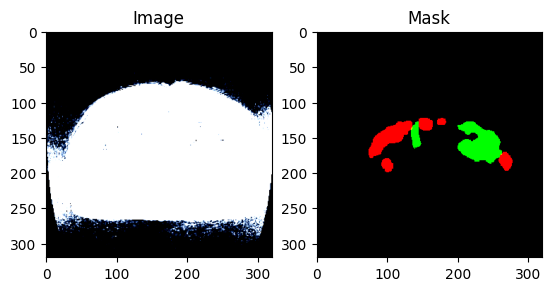

In [ ]:
sample_img, sample_mask = next(iter(train_loader))

# pick first in batch
plt.subplot(1,2,1)
plt.imshow(sample_img[0].permute(1,2,0))
plt.title("Image")

plt.subplot(1,2,2)
plt.imshow(sample_mask[0])
plt.title("Mask")

In [ ]:
# ---- UNet and optimizer initialization----
unet_model = UNet(in_channels=3, num_classes=3).to(device)
unet_optimizer = Adam(unet_model.parameters(), lr=1e-4)

NUM_EPOCHS_UNET = 7  # Maybe increase to 20 to match the TransUNet or not.

best_unet_val_dice = 0.0
best_unet_state = None

train_history_unet = {
    "train_loss": [],
    "train_dice": [],
    "val_loss": [],
    "val_dice": []
}

for epoch in range(1, NUM_EPOCHS_UNET + 1):
    train_loss, train_dice = train_unet_one_epoch(unet_model, train_loader, unet_optimizer, device)
    val_loss, val_dice = validate_unet_one_epoch(unet_model, val_loader, device)

    train_history_unet["train_loss"].append(train_loss)
    train_history_unet["train_dice"].append(train_dice)
    train_history_unet["val_loss"].append(val_loss)
    train_history_unet["val_dice"].append(val_dice)

    print(
        f"[UNet] Epoch {epoch}/{NUM_EPOCHS_UNET} | "
        f"Train Loss: {train_loss:.4f}  Train Dice: {train_dice:.4f} | "
        f"Val Loss: {val_loss:.4f}  Val Dice: {val_dice:.4f}"
    )

    # Track best model based on validation Dice
    if val_dice > best_unet_val_dice:
        best_unet_val_dice = val_dice
        best_unet_state = unet_model.state_dict()

print(f"\n[UNet] Best validation Dice: {best_unet_val_dice:.4f}")

# loading and saving the best weights
if best_unet_state is not None:
    unet_model.load_state_dict(best_unet_state)

torch.save(unet_model.state_dict(), "best_unet_model_7.pth")
print("Saved best UNet model to best_unet_model.pth")

  [UNet] Batch 0/1662  Loss: 0.7696
  [UNet] Batch 10/1662  Loss: 0.6524
  [UNet] Batch 20/1662  Loss: 0.5975
  [UNet] Batch 30/1662  Loss: 0.5552
  [UNet] Batch 40/1662  Loss: 0.5635
  [UNet] Batch 50/1662  Loss: 0.5315
  [UNet] Batch 60/1662  Loss: 0.5151
  [UNet] Batch 70/1662  Loss: 0.5007
  [UNet] Batch 80/1662  Loss: 0.4918
  [UNet] Batch 90/1662  Loss: 0.4775
  [UNet] Batch 100/1662  Loss: 0.4796
  [UNet] Batch 110/1662  Loss: 0.4696
  [UNet] Batch 120/1662  Loss: 0.4596
  [UNet] Batch 130/1662  Loss: 0.4492
  [UNet] Batch 140/1662  Loss: 0.4419
  [UNet] Batch 150/1662  Loss: 0.4355
  [UNet] Batch 160/1662  Loss: 0.4316
  [UNet] Batch 170/1662  Loss: 0.4234
  [UNet] Batch 180/1662  Loss: 0.4116
  [UNet] Batch 190/1662  Loss: 0.4053
  [UNet] Batch 200/1662  Loss: 0.4071
  [UNet] Batch 210/1662  Loss: 0.4049
  [UNet] Batch 220/1662  Loss: 0.3914
  [UNet] Batch 230/1662  Loss: 0.3837
  [UNet] Batch 240/1662  Loss: 0.3744
  [UNet] Batch 250/1662  Loss: 0.3691
  [UNet] Batch 260/1662

KeyboardInterrupt: 

# Evaluation of both UNet and TransUNet models



This first cell here is a function for computing the dice score (between 0 and 1) for every class (Like stomach, bowels, and such). Both the UNet and TransUnet model will be evaluated using this function.

In [ ]:
def compute_dice_per_class(logits, targets, eps=1e-6):
    """
    logits: (B, C, H, W) raw scores
    targets: (B, C, H, W) 0/1 float or bool
    Returns: (C,) numpy array of Dice scores per class
    """
    probs = torch.sigmoid(logits)

    # Flatten spatial dims
    probs_flat = probs.view(probs.size(0), probs.size(1), -1)       # (B, C, HW)
    targets_flat = targets.view(targets.size(0), targets.size(1), -1)

    intersection = (probs_flat * targets_flat).sum(-1)              # (B, C)
    union = probs_flat.sum(-1) + targets_flat.sum(-1)               # (B, C)
    dice_per_class = (2.0 * intersection + eps) / (union + eps)     # (B, C)

    # Average over batch → (C,)
    return dice_per_class.mean(dim=0).cpu().numpy()


@torch.no_grad()
def evaluate_model(model, loader, device, loss_fn, name="model", threshold=0.5):
    """
    Run full validation for a model.
    Returns a dict with:
        mean_loss, mean_dice, dice_per_class (np.array length 3)
    """
    model.eval()

    total_loss = 0.0
    total_dice = 0.0
    num_batches = 0

    # For per-class dice, we accumulate numerators/denominators to avoid storing all batches
    C = 3  # num classes
    num_intersection = np.zeros(C, dtype=np.float64)
    num_union = np.zeros(C, dtype=np.float64)
    eps = 1e-6

    for images, masks in loader:
        images = images.to(device)

        # Handle mask shape: (B, H, W, C) -> (B, C, H, W)
        if masks.ndim == 4 and masks.shape[1] != C and masks.shape[-1] == C:
            masks = masks.permute(0, 3, 1, 2)
        masks = masks.to(device)

        logits = model(images)
        loss = loss_fn(logits, masks)
        total_loss += loss.item()

        # ---- Dice for this batch ----
        probs = torch.sigmoid(logits)
        probs_flat = probs.view(probs.size(0), C, -1)
        targets_flat = masks.view(masks.size(0), C, -1)

        intersection = (probs_flat * targets_flat).sum(-1)      # (B, C)
        union = probs_flat.sum(-1) + targets_flat.sum(-1)       # (B, C)
        dice_batch = (2.0 * intersection + eps) / (union + eps) # (B, C)

        # mean Dice over classes & batch
        total_dice += dice_batch.mean().item()

        # accumulate per-class numerators/denominators
        num_intersection += intersection.sum(dim=0).cpu().numpy()
        num_union += union.sum(dim=0).cpu().numpy()

        num_batches += 1

    mean_loss = total_loss / max(num_batches, 1)
    mean_dice = total_dice / max(num_batches, 1)

    dice_per_class = (2.0 * num_intersection + eps) / (num_union + eps)

    print(f"[{name}] Val Loss: {mean_loss:.4f} | Val Dice: {mean_dice:.4f}")
    print(f"[{name}] Per-class Dice (stomach, small bowel, large bowel): {dice_per_class}")

    return {
        "mean_loss": mean_loss,
        "mean_dice": mean_dice,
        "dice_per_class": dice_per_class,
    }

In [ ]:
@torch.no_grad()
def compare_models_on_val_batch(
    unet_model,
    transunet_model,
    loader,
    device,
    num_samples=3,
    threshold=0.5,
):
    """
    Show original image, GT mask, UNet prediction, TransUNet prediction
    for a few samples from the validation set.
    """
    unet_model.eval()
    transunet_model.eval()

    batch = next(iter(loader))
    images, masks = batch

    # Make sure we don't ask for more samples than the batch has
    num_samples = min(num_samples, images.size(0))

    images = images.to(device)

    # Handle mask shape: (B, H, W, C) -> (B, C, H, W)
    if masks.ndim == 4 and masks.shape[1] != 3 and masks.shape[-1] == 3:
        masks = masks.permute(0, 3, 1, 2)
    masks = masks.to(device)

    # Forward both models
    logits_unet = unet_model(images)
    logits_trans = transunet_model(images)

    probs_unet = torch.sigmoid(logits_unet)
    probs_trans = torch.sigmoid(logits_trans)

    preds_unet = (probs_unet > threshold).float()
    preds_trans = (probs_trans > threshold).float()

    # Move everything to CPU for plotting
    images = images.cpu()
    masks = masks.cpu()
    preds_unet = preds_unet.cpu()
    preds_trans = preds_trans.cpu()

    for i in range(num_samples):
        img = images[i].permute(1, 2, 0)          # (H, W, 3)
        gt_mask = masks[i].permute(1, 2, 0)       # (H, W, 3)
        unet_mask = preds_unet[i].permute(1, 2, 0)
        trans_mask = preds_trans[i].permute(1, 2, 0)

        fig, axs = plt.subplots(1, 4, figsize=(16, 4))

        axs[0].imshow(img)
        axs[0].set_title("Image")
        axs[0].axis("off")

        axs[1].imshow(gt_mask)
        axs[1].set_title("Ground Truth Mask")
        axs[1].axis("off")

        axs[2].imshow(unet_mask)
        axs[2].set_title("UNet Prediction")
        axs[2].axis("off")

        axs[3].imshow(trans_mask)
        axs[3].set_title("TransUNet Prediction")
        axs[3].axis("off")

        plt.tight_layout()
        plt.show()

### Evaluation, Visualization & Error Analysis

Imports and Device Setup


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


Load Models & Information

Load in the trained weights from the saved model files.

In [ ]:

def load_model(constructor, ckpt_path):
    model = constructor().to(device)
    state = torch.load(ckpt_path, map_location=device)

    # try raw
    try:
        model.load_state_dict(state)
    except:
        # try nested dict
        if "model" in state:
            model.load_state_dict(state["model"])
        elif "state_dict" in state:
            model.load_state_dict(state["state_dict"])
        else:
            raise RuntimeError("Unknown checkpoint format.")

    model.eval()
    print(f"Loaded model from {ckpt_path}")
    return model


# ============================
# Cell 2 — Load Models
# ============================

UNET_CKPT = "drive/.shortcut-targets-by-id/1UkBiwI9Rz9d0fOWwfK9lmRgQ5FK_K5VV/CMPM118/best_unet_model_7.pth"
TRANS_CKPT = "drive/.shortcut-targets-by-id/1UkBiwI9Rz9d0fOWwfK9lmRgQ5FK_K5VV/CMPM118/best_transunet_model.pth"

unet = load_model(lambda: UNet(in_channels=3, num_classes=3), UNET_CKPT)
trans = load_model(lambda: TransUnet(in_channels=3, num_classes=3, img_size=320), TRANS_CKPT)


Loaded model from drive/.shortcut-targets-by-id/1UkBiwI9Rz9d0fOWwfK9lmRgQ5FK_K5VV/CMPM118/best_unet_model_7.pth
Loaded model from drive/.shortcut-targets-by-id/1UkBiwI9Rz9d0fOWwfK9lmRgQ5FK_K5VV/CMPM118/best_transunet_model.pth


Metrics & Predictions



1.   Dice Score Function:
Computes the Dice Score which calculates the dice coefficient (the overlap between the model predictions and the real outputs).It flattens the predictions and truths, computes the intersection, dice score and produces a value between 0 and 1.

2.   IoU Function;
Computer the intersection-over-union, another metric which will place more focus on the mistakes. The function flattens the inputs, computes the intersection and union, then reterns a IoU score similar to Dice (from 0 to 1).

3. Prediction Mask Function:
Converts the logits, the raw model output, into a segmentation mask that makes the scoring process smoother. If the logits are binary, it will convert them into probabilities and produces a 0/1 mask. However, if they are multi-class, softmax is applied to get class probabilities, then argmax to choose a class, and produces a labeled map with values.

4. Mask Resize Function:
The model predictions are resized so that they can be accurately compared with the truth masks and have the same dimensions.



In [ ]:

EPS = 1e-8

def dice_score(pred, true):
    # treat nonzero pixels as foreground
    p = (pred > 0).astype(np.uint8)
    t = (true > 0).astype(np.uint8)

    p = p.flatten()
    t = t.flatten()

    inter = (p & t).sum()
    return (2 * inter) / (p.sum() + t.sum() + EPS)


def iou_score(pred, true):
    p = pred.flatten()
    t = true.flatten()
    inter = (p * t).sum()
    union = (p.sum() + t.sum() - inter)
    return inter / (union + EPS)


def pred_mask(model, img, threshold=0.5):
    with torch.no_grad():
        logits = model(img.unsqueeze(0).to(device))

        if logits.shape[1] == 1:   # binary
            return (torch.sigmoid(logits)[0,0] >= threshold).cpu().numpy().astype(np.uint8)
        else:                      # multi-class
            return torch.argmax(F.softmax(logits, dim=1), dim=1)[0].cpu().numpy().astype(np.uint8)


def resize_mask(mask, target_hw):
    h, w = target_hw
    return cv2.resize(mask.astype(np.uint8), (w, h), interpolation=cv2.INTER_NEAREST)


Evaluation Loop:



*   Loops through the validation dataloader, image by image inside each batch and moves each image and mask to be processed.
*   Normalizes the real mask shapes
*   Resizes to match model predictions



In [ ]:

results = []

for imgs, masks in val_loader:
    for i in range(len(imgs)):
        img_tensor = imgs[i]
        mask = masks[i].cpu().numpy()

        # ---- Normalize GT mask to 2D ----
        if mask.ndim == 2:
            gt = mask
        elif mask.ndim == 3 and mask.shape[0] == 1:
            gt = mask[0]
        elif mask.ndim == 3 and mask.shape[0] > 1:      # (C,H,W)
            gt = np.argmax(mask, axis=0)
        elif mask.ndim == 3 and mask.shape[-1] > 1:     # (H,W,C)
            gt = np.argmax(mask, axis=-1)
        else:
            raise ValueError(f"Bad mask shape: {mask.shape}")

        # ---- Predictions ----
        pred_u = pred_mask(unet, img_tensor)
        pred_t = pred_mask(trans, img_tensor)

        # ---- Resize GT to match prediction ----
        gt = resize_mask(gt, pred_u.shape)

        # ---- Metrics ----
        dice_u = dice_score(pred_u, gt)
        dice_t = dice_score(pred_t, gt)

        results.append({
            "image": img_tensor.permute(1,2,0).cpu().numpy(),
            "gt": gt,
            "unet": pred_u,
            "trans": pred_t,
            "dice_unet": dice_u,
            "dice_trans": dice_t
        })

print("Processed", len(results), "validation samples")


Processed 7700 validation samples


Summary Stats & Graphs



*   Extracts the dice scores for the UNet and TrasnUNet models -> used to compute the mean Dice Scores of each model. Higher dice score implies a better model performance.
*   Line Plot: Dice Score per Validation Sample. Shows how the performance of each model varies per image. (helpful for diagnosing cases where a model can fail)
*   IoU Comparison Curves: IoU points out the false positives more than Dice Scores.

* Scatter Plot: Red diagonal represents similar performance of both models, points above diagonal indicates better TransUNet performance, while points below the diagonal indicate UNet is better.

* Win/Loss Comparison: compares how many images the models performed better on.


UNet   mean Dice: 0.1328750528558314
TransU mean Dice: 0.09191335262369817


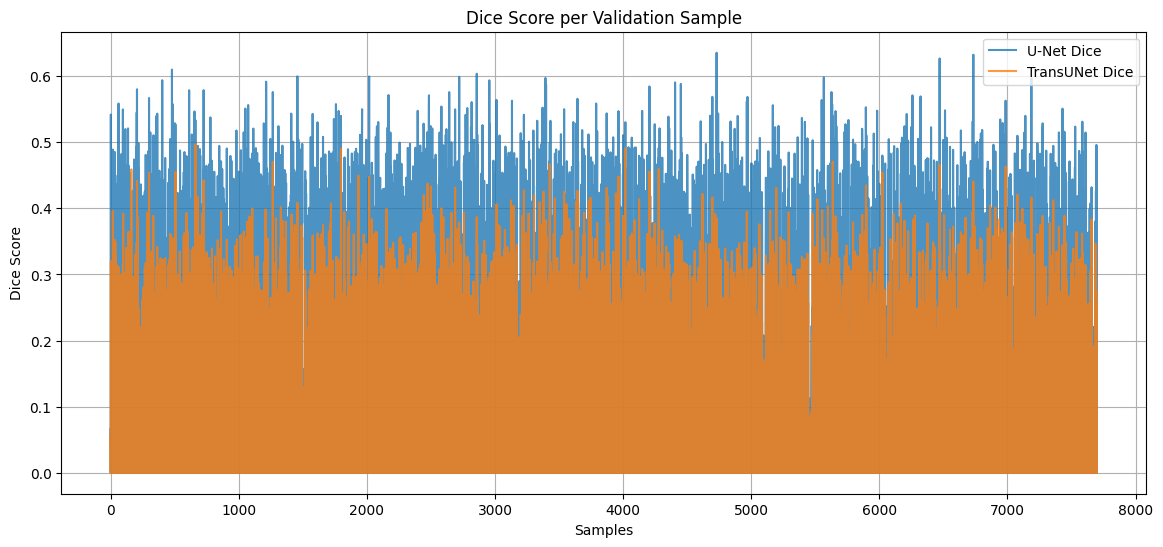

/tmp/ipython-input-2212976383.py:19: RuntimeWarning: overflow encountered in scalar subtract
  union = (p.sum() + t.sum() - inter)


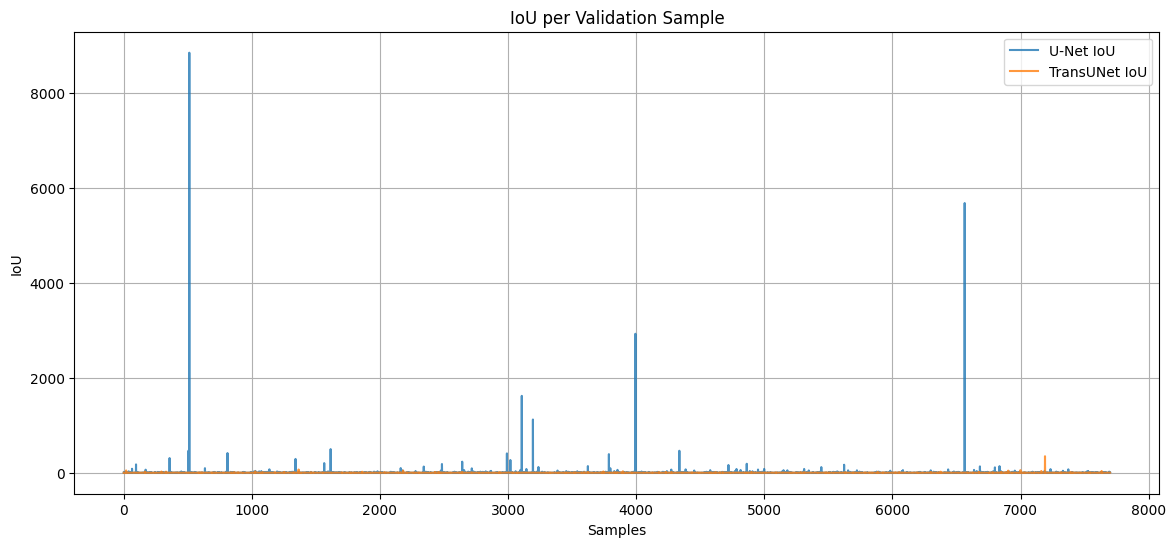

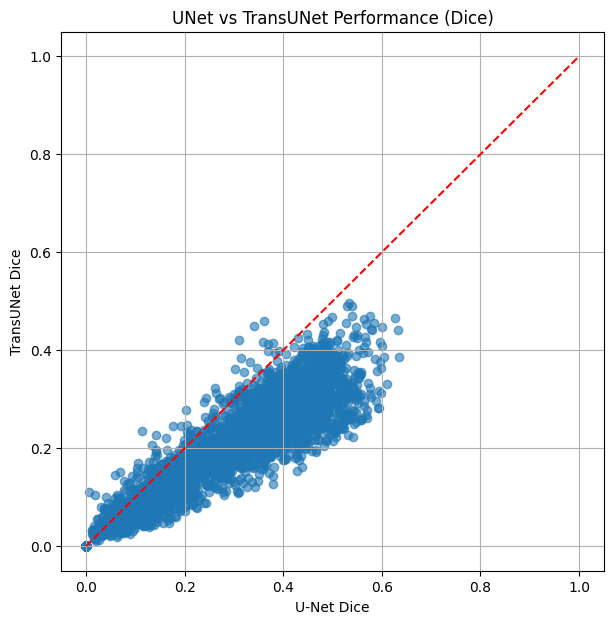


===== Model Comparison: Win / Loss =====
Images where U-Net performed better:       3082 (40.03%)
Images where TransUNet performed better:   219 (2.84%)


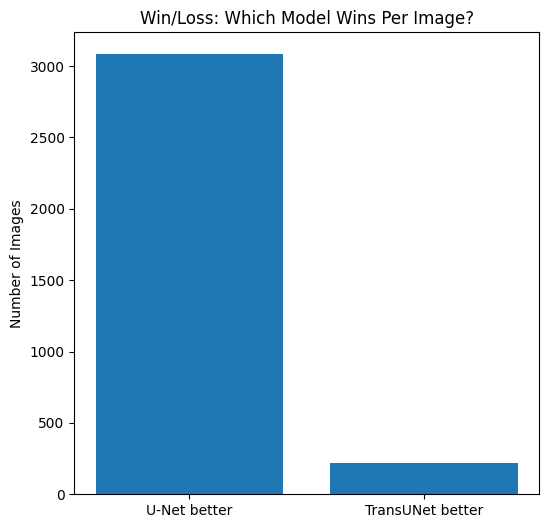

In [ ]:

dice_u = np.array([r["dice_unet"] for r in results])
dice_t = np.array([r["dice_trans"] for r in results])

# Summary stats
print("UNet   mean Dice:", np.mean(dice_u))
print("TransU mean Dice:", np.mean(dice_t))

# ----------------------------------------
# 1. Line Plot of Dice Scores Per Sample
# ----------------------------------------

plt.figure(figsize=(14,6))
plt.plot(dice_u, label="U-Net Dice", alpha=0.8)
plt.plot(dice_t, label="TransUNet Dice", alpha=0.8)
plt.title("Dice Score per Validation Sample")
plt.xlabel("Samples")
plt.ylabel("Dice Score")
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------------------
# 2. IoU comparison curves
# ----------------------------------------
iou_u = np.array([iou_score(r["unet"], r["gt"]) for r in results])
iou_t = np.array([iou_score(r["trans"], r["gt"]) for r in results])

plt.figure(figsize=(14,6))
plt.plot(iou_u, label="U-Net IoU", alpha=0.8)
plt.plot(iou_t, label="TransUNet IoU", alpha=0.8)
plt.title("IoU per Validation Sample")
plt.xlabel("Samples")
plt.ylabel("IoU")
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------------------
# 3. Scatter plot: model-vs-model accuracy
# ----------------------------------------

plt.figure(figsize=(7,7))
plt.scatter(dice_u, dice_t, alpha=0.6)
plt.plot([0,1],[0,1], 'r--')   # diagonal line
plt.xlabel("U-Net Dice")
plt.ylabel("TransUNet Dice")
plt.title("UNet vs TransUNet Performance (Dice)")
plt.grid(True)
plt.show()

# ----------------------------------------
# 4. Win/Loss comparison
# ----------------------------------------

unet_better = np.sum(dice_u > dice_t)
trans_better = np.sum(dice_t > dice_u)

print("\n===== Model Comparison: Win / Loss =====")
print(f"Images where U-Net performed better:       {unet_better} ({unet_better/len(results)*100:.2f}%)")
print(f"Images where TransUNet performed better:   {trans_better} ({trans_better/len(results)*100:.2f}%)")

plt.figure(figsize=(6,6))
plt.bar(["U-Net better", "TransUNet better"], [unet_better, trans_better])
plt.title("Win/Loss: Which Model Wins Per Image?")
plt.ylabel("Number of Images")
plt.show()


Qualitative Examples

Visualize the individiual validation samples with the original CT scan, the ground truth segmentation, UNet and TransUNet predictions.

Showing WORST example:


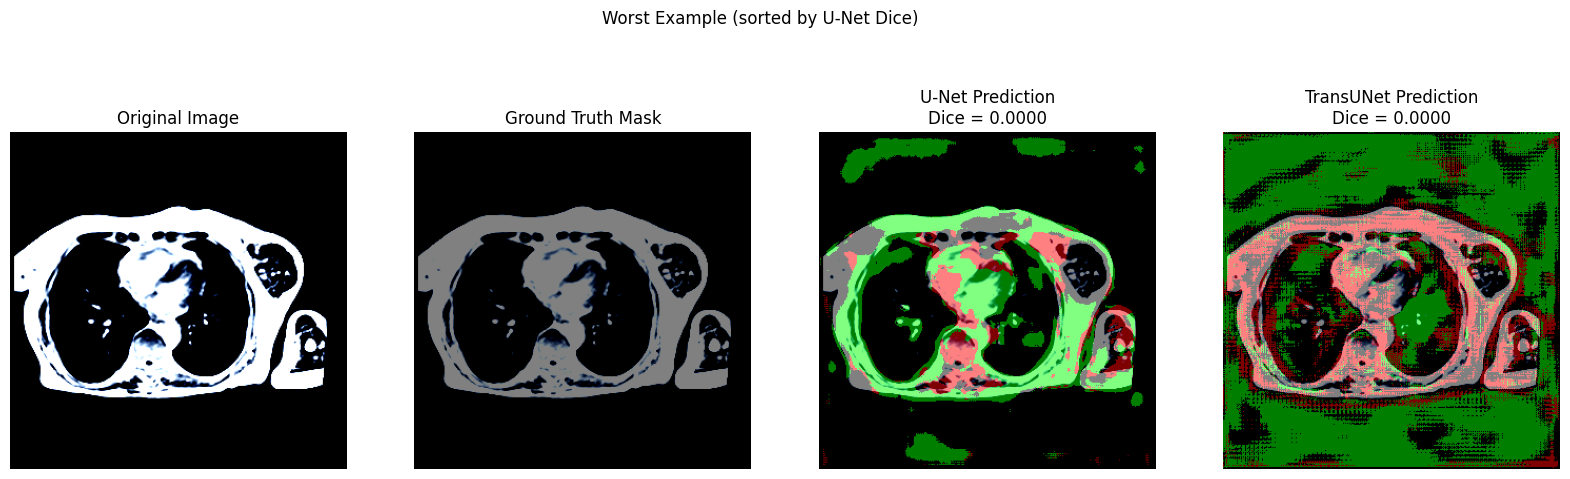

Showing BEST example:


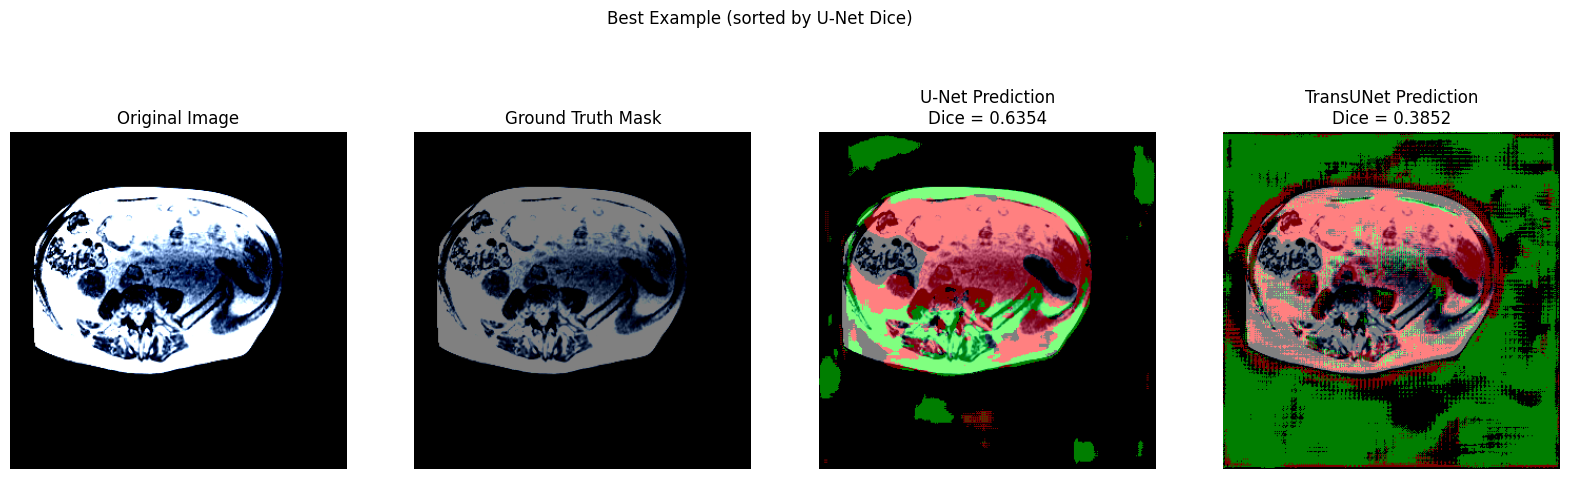

Showing RANDOM example:


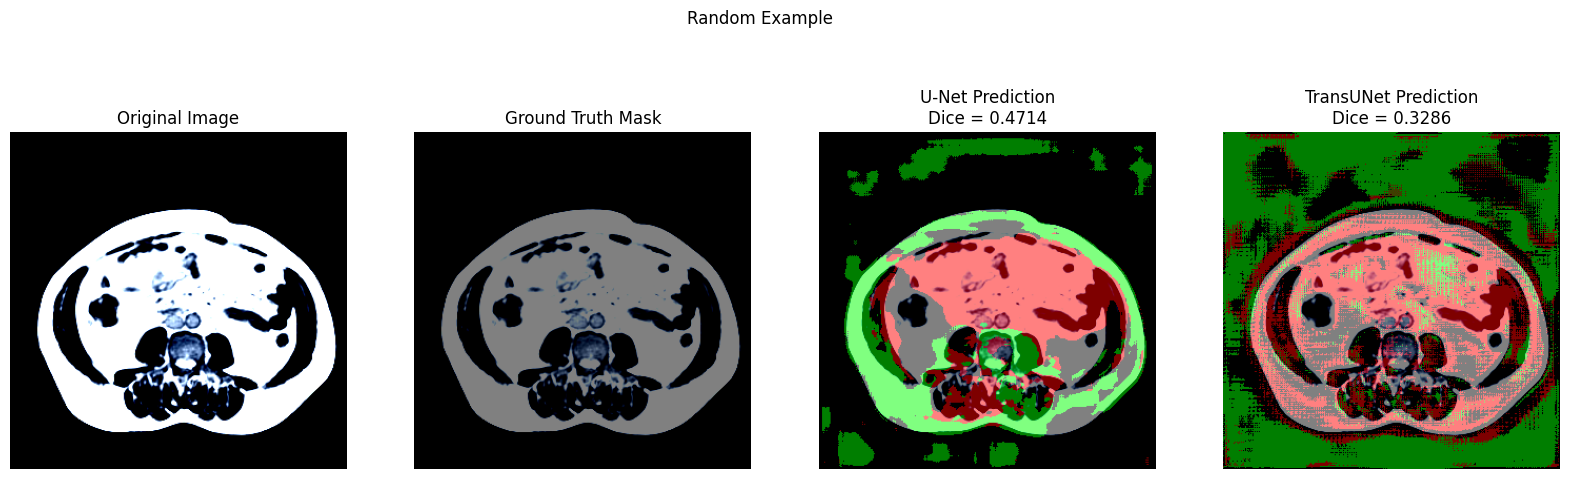

In [ ]:
# ============================
# Cell 6 — Better Visualization
# ============================

import matplotlib.pyplot as plt
import numpy as np

# A fixed color palette (class → RGB)
CLASS_COLORS = np.array([
    [0, 0, 0],         # class 0 = background (black)
    [255, 0, 0],       # class 1 = red
    [0, 255, 0],       # class 2 = green
    [0, 0, 255],       # class 3 = blue
    [255, 255, 0],     # class 4 = yellow
    [255, 165, 0],     # class 5 = orange
], dtype=np.uint8)

def colorize_mask(mask):
    """Convert integer mask to RGB mask using the fixed palette."""
    h, w = mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)

    max_class = min(mask.max(), CLASS_COLORS.shape[0] - 1)

    for c in range(max_class + 1):
        rgb[mask == c] = CLASS_COLORS[c]

    return rgb


def show_example(result, title):
    img = result["image"]
    gt = colorize_mask(result["gt"])
    unet_pred = colorize_mask(result["unet"])
    trans_pred = colorize_mask(result["trans"])

    fig, axes = plt.subplots(1, 4, figsize=(20, 6))

    # 1) original CT scan
    axes[0].imshow(img, cmap="gray")
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # 2) ground truth overlay
    axes[1].imshow(img, cmap="gray")
    axes[1].imshow(gt, alpha=0.5)
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis("off")

    # 3) UNet overlay
    axes[2].imshow(img, cmap="gray")
    axes[2].imshow(unet_pred, alpha=0.5)
    axes[2].set_title(f"U-Net Prediction\nDice = {result['dice_unet']:.4f}")
    axes[2].axis("off")

    # 4) TransUNet overlay
    axes[3].imshow(img, cmap="gray")
    axes[3].imshow(trans_pred, alpha=0.5)
    axes[3].set_title(f"TransUNet Prediction\nDice = {result['dice_trans']:.4f}")
    axes[3].axis("off")

    plt.suptitle(title)
    plt.show()


# Sort results by UNet performance
sorted_results = sorted(results, key=lambda r: r["dice_unet"])

print("Showing WORST example:")
show_example(sorted_results[0], "Worst Example (sorted by U-Net Dice)")

print("Showing BEST example:")
show_example(sorted_results[-1], "Best Example (sorted by U-Net Dice)")

print("Showing RANDOM example:")
import random
show_example(random.choice(results), "Random Example")
